## DC Metro Analysis

### Bus Route Diagnostics: 
Evaluated route efficiency and visualized geospatial demand "hotzones" across the DC area.

### Temporal Traffic Patterns: 
Mapped system-wide rail intensity to identify peak usage windows and weekly bottlenecks.

### Passenger Flow Modeling:
Constructed a synthetic Origin-Destination (OD) matrix to estimate station-to-station ridership.

### Network Topology:
Built a graph of the physical rail system to isolate critical hubs and structural vulnerabilities.

In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Data paths
BUS_DATA_PATH = './data/csv_format/BusRdr_Routes_Stops_Time_Periods.csv'
rail_pattern = './data/csv_format/Metro_Rail_Ridership_Dataset_Summary_*.csv'
rail_files = sorted(glob.glob(rail_pattern))

print(f"Setup complete. Found {len(rail_files)} rail data files.")

Setup complete. Found 4 rail data files.


In [2]:
# Ingest Data Functions

def load_bus_data(filepath):
    df = pd.read_csv(filepath)
    df[['LAT', 'LON']] = df[['LAT', 'LON']].apply(pd.to_numeric, errors='coerce')
    print(f"Bus Data Loaded: {df.shape}")
    return df

def load_rail_data(file_list):
    df = pd.concat((pd.read_csv(f) for f in file_list), ignore_index=True)
    if 'SVC_DATE' in df.columns:
        df['SVC_DATE'] = pd.to_datetime(df['SVC_DATE'])
    print(f"Rail Data Loaded: {df.shape}")
    return df

bus_df = load_bus_data(BUS_DATA_PATH)
rail_df = load_rail_data(rail_files)

Bus Data Loaded: (217366, 14)


C:\Users\Varun\AppData\Local\Temp\ipykernel_71492\1202062985.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['SVC_DATE'] = pd.to_datetime(df['SVC_DATE'])


Rail Data Loaded: (4047779, 8)


Top 10 High-Traffic Bus Routes:


,AVG_LOAD,MAX_LOAD
ROUTE_NAME,,
M12,9.796504,14.926190
D80,8.458100,14.519647
D4X,9.903235,14.445377
M20,9.693570,14.244090
D40,9.059127,13.714914
F81,9.863145,13.533858
D50,8.266840,13.319215
F20,8.164268,13.065502
C87,7.051227,12.701737


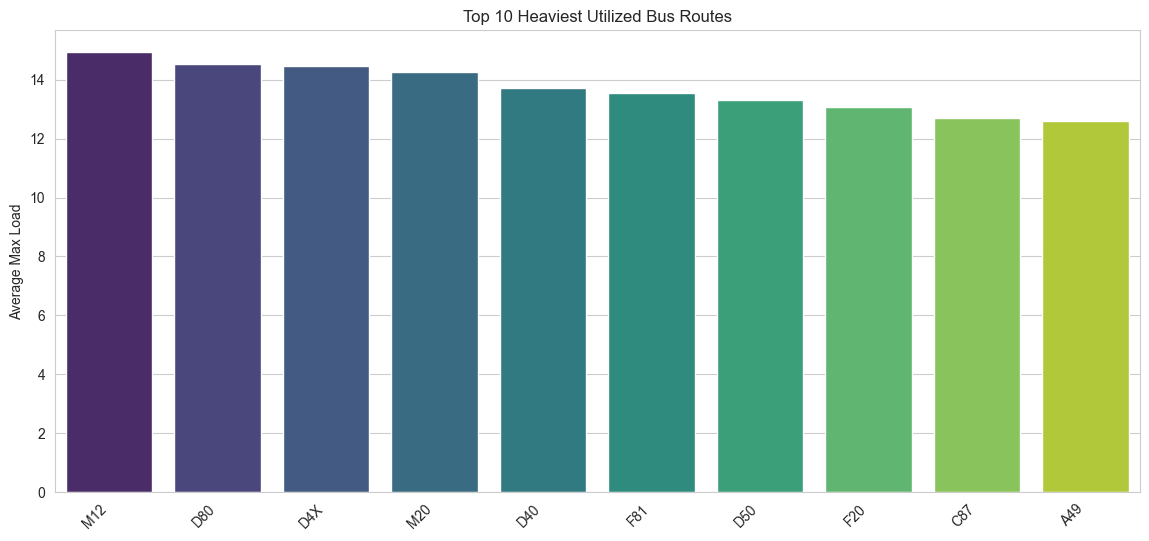

In [3]:
# Analyze Bus Loads

# Identify top routes by load
route_load = bus_df.groupby('ROUTE_NAME')[['AVG_LOAD', 'MAX_LOAD']].mean() \
                   .sort_values('MAX_LOAD', ascending=False).head(10)

print("Top 10 High-Traffic Bus Routes:")
display(route_load)

# Visualize load distribution
plt.figure(figsize=(14, 6))
sns.barplot(x=route_load.index, y=route_load['MAX_LOAD'], palette='viridis', hue=route_load.index)
plt.title('Top 10 Heaviest Utilized Bus Routes')
plt.ylabel('Average Max Load')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

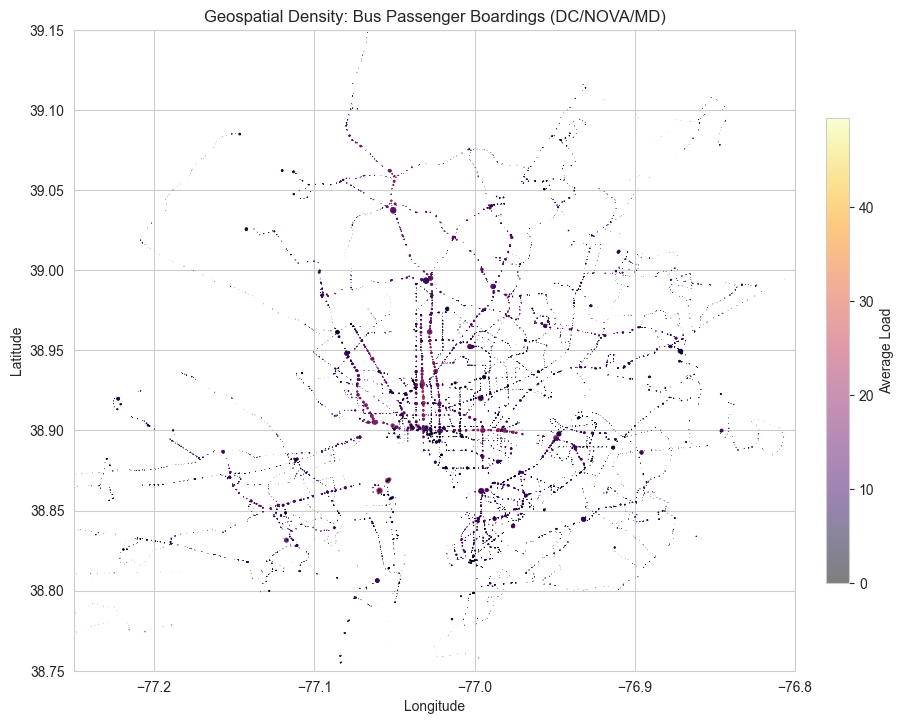

In [4]:
# Geospatial Bus Density

# Filter valid coordinates
geo_bus = bus_df[(bus_df['LAT'] != 0) & (bus_df['LON'] != 0)].dropna(subset=['LAT', 'LON'])

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot: Weighted by Passengers
sc = ax.scatter(
    geo_bus['LON'], 
    geo_bus['LAT'], 
    s=geo_bus['SUM_PASSENGERS_ON'] * 0.05,  # Adjusted scale for clarity
    c=geo_bus['AVG_LOAD'], 
    cmap='inferno', 
    alpha=0.5,
    edgecolors='none'
)

# Formatting as a Map
ax.set_title('Geospatial Density: Bus Passenger Boardings (DC/NOVA/MD)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')  # Crucial for correct map proportions
plt.colorbar(sc, label='Average Load', fraction=0.03, pad=0.04)

# Focus on DC Metro Area Bounds
ax.set_xlim(-77.25, -76.80)
ax.set_ylim(38.75, 39.15)

plt.show()

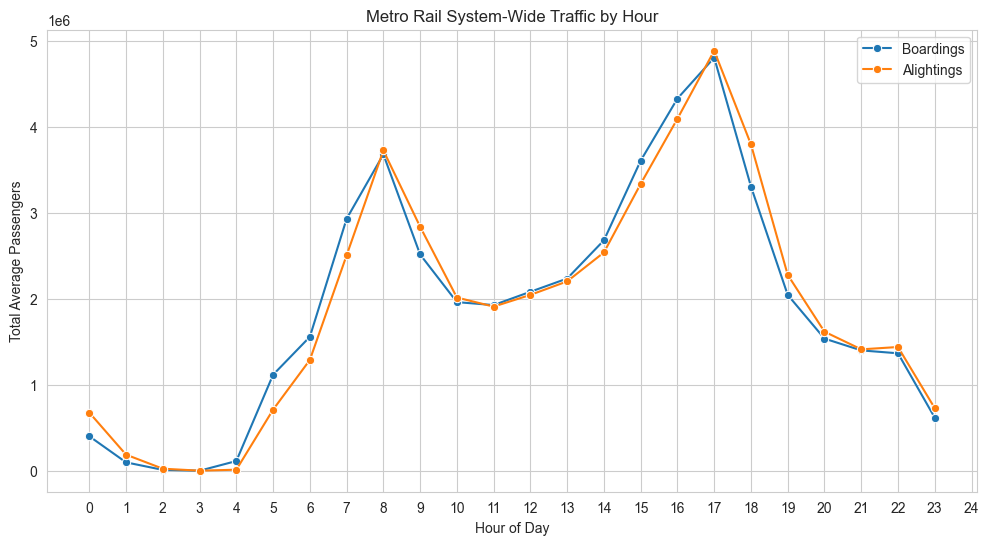


Top 10 Busiest Station IDs:
STOP_ID
C01    2686486
C05    2433578
F03    2336934
D03    2234895
F01    1721271
A01    1537080
C04    1505617
B01    1447200
C07    1195269
C03     994163
Name: AVG_BOARDINGS, dtype: int64


In [5]:
# Rail Temporal Analysis

# Group by Hour to see system-wide peak times
hourly_traffic = rail_df.groupby('HOUR')[['AVG_BOARDINGS', 'AVG_ALIGHTINGS']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_traffic, x='HOUR', y='AVG_BOARDINGS', label='Boardings', marker='o')
sns.lineplot(data=hourly_traffic, x='HOUR', y='AVG_ALIGHTINGS', label='Alightings', marker='o')

plt.title('Metro Rail System-Wide Traffic by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Average Passengers')
plt.xticks(range(0, 25))
plt.legend()
plt.grid(True)
plt.show()

# Check specific high-traffic stops
# Note: We only have STOP_ID here. We will eventually need a mapping file to know Station Names.
top_stations = rail_df.groupby('STOP_ID')['AVG_BOARDINGS'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Busiest Station IDs:")
print(top_stations)

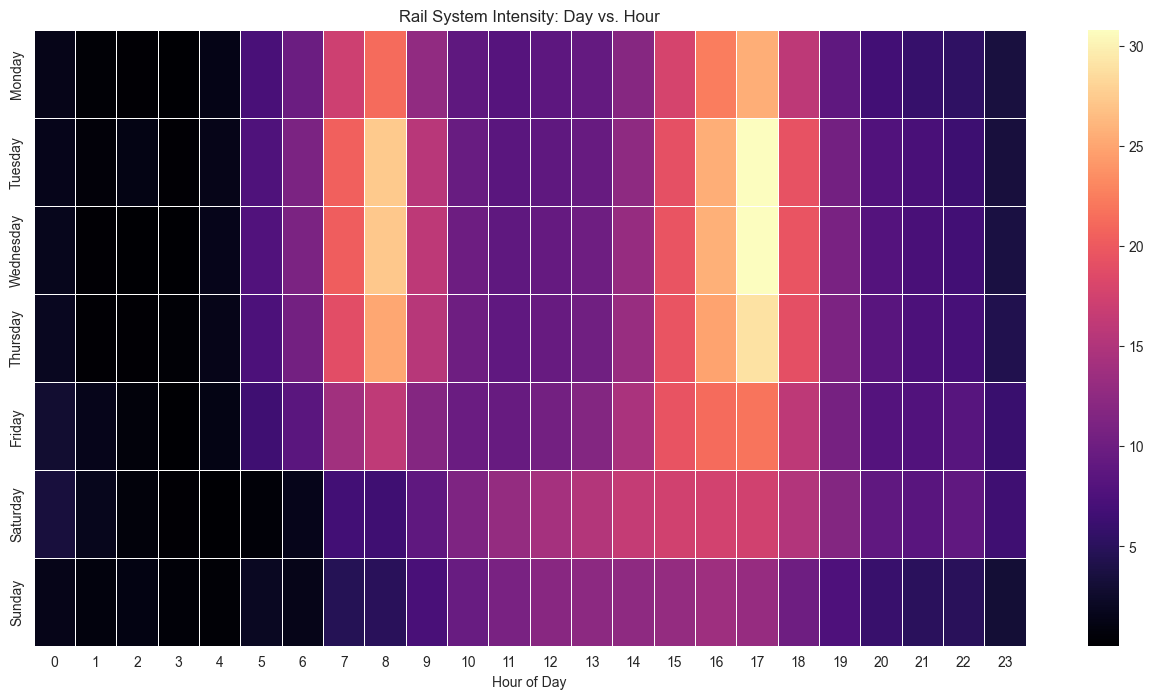

In [6]:
# Weekly Traffic Intensity

# Ensure day names are present and sorted
rail_df['Day_Name'] = rail_df['SVC_DATE'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create matrix: Day vs Hour
rail_pivot = rail_df.pivot_table(
    index='Day_Name', 
    columns='HOUR', 
    values='AVG_BOARDINGS', 
    aggfunc='mean'
).reindex(days_order)

# Visualize Temporal Bottlenecks
plt.figure(figsize=(16, 8))
sns.heatmap(rail_pivot, cmap='magma', linewidths=.5)
plt.title('Rail System Intensity: Day vs. Hour')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.show()

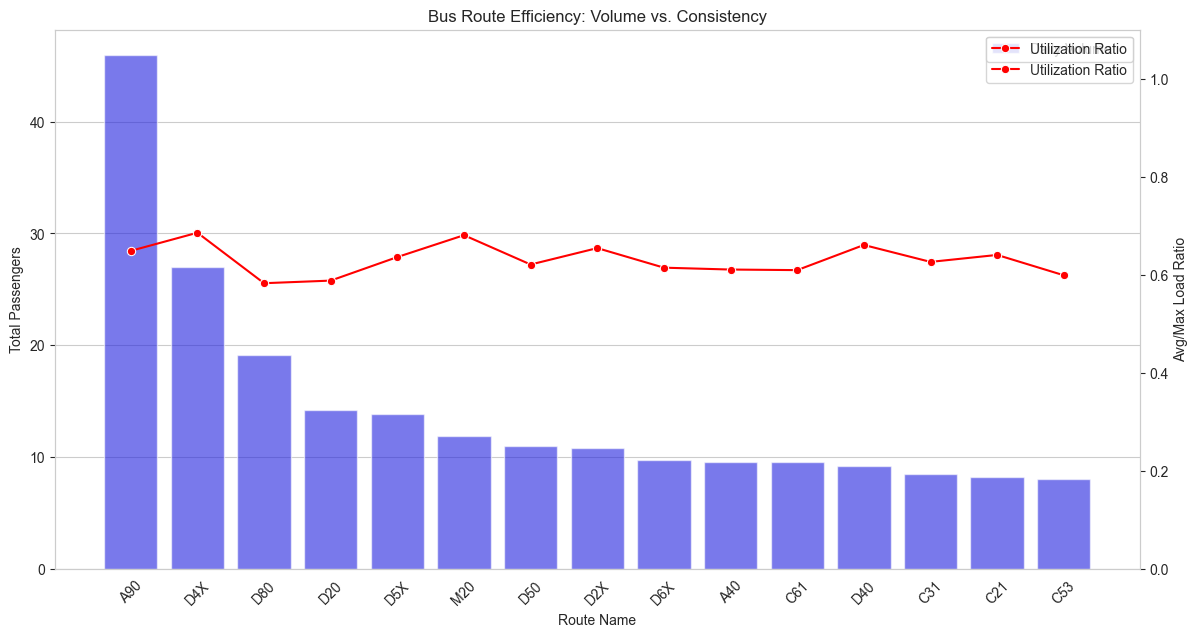

In [7]:
# Bus Efficiency Metrics

# Calculate Volume vs. Utilization metrics
bus_metrics = bus_df.groupby('ROUTE_NAME')[['AVG_LOAD', 'MAX_LOAD', 'SUM_PASSENGERS_ON']].mean()
bus_metrics['UTILIZATION_RATIO'] = bus_metrics['AVG_LOAD'] / bus_metrics['MAX_LOAD']

# Identify top 15 routes by volume
top_routes = bus_metrics.sort_values('SUM_PASSENGERS_ON', ascending=False).head(15)

# Dual-axis visualization
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar Plot: Volume
sns.barplot(x=top_routes.index, y=top_routes['SUM_PASSENGERS_ON'], alpha=0.6, color='blue', ax=ax1, label='Daily Volume')
ax1.set_ylabel('Total Passengers')
ax1.set_xlabel('Route Name')
ax1.tick_params(axis='x', rotation=45)

# Line Plot: Efficiency
ax2 = ax1.twinx()
sns.lineplot(x=top_routes.index, y=top_routes['UTILIZATION_RATIO'], color='red', marker='o', ax=ax2, label='Utilization Ratio')
ax2.set_ylabel('Avg/Max Load Ratio')
ax2.set_ylim(0, 1.1)
ax2.grid(False)

# Unified Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Bus Route Efficiency: Volume vs. Consistency')
plt.show()

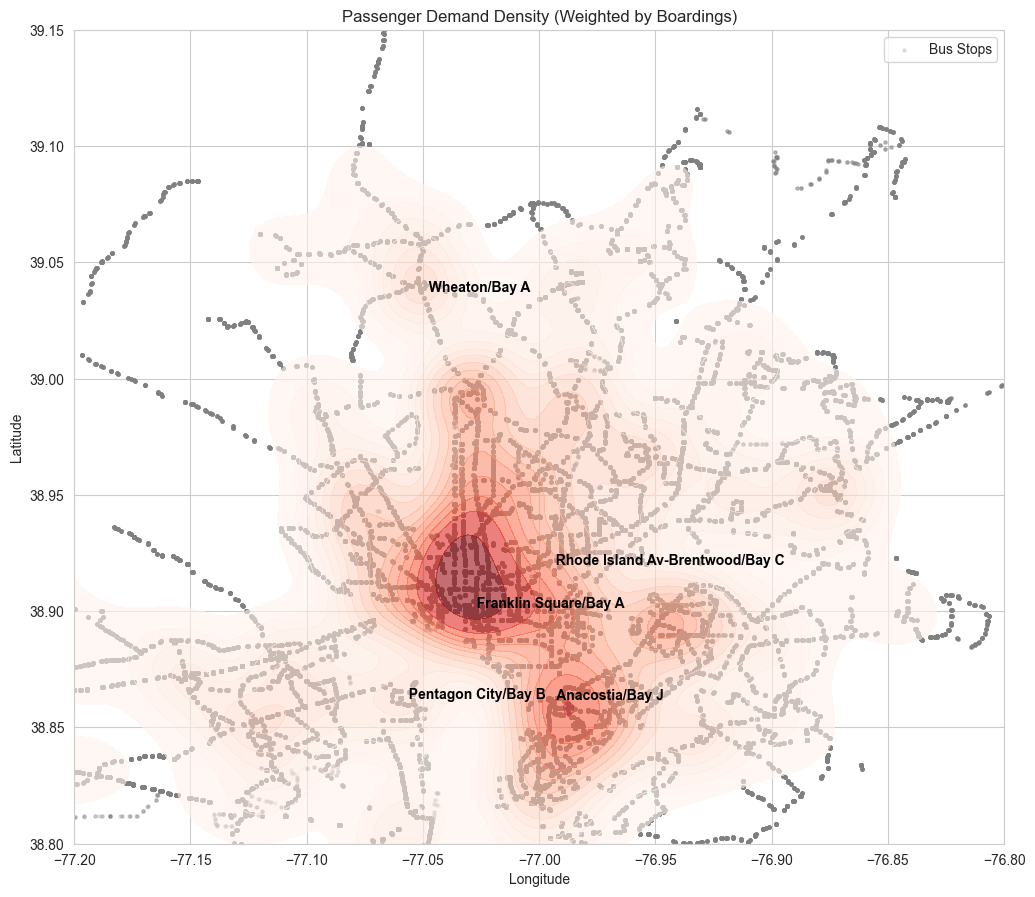

In [8]:
# Demand Density Heatmap

# Filter valid coordinates
geo_data = bus_df[(bus_df['LAT'] != 0) & (bus_df['LON'] != 0)].dropna(subset=['LAT', 'LON'])

# Setup Map Canvas
fig, ax = plt.subplots(figsize=(12, 12))

# 1. Base Layer: All Stops (Context)
ax.scatter(geo_data['LON'], geo_data['LAT'], c='gray', s=5, alpha=0.2, label='Bus Stops')

# 2. Density Layer: Passenger Heatmap
sns.kdeplot(
    x=geo_data['LON'], 
    y=geo_data['LAT'], 
    weights=geo_data['SUM_PASSENGERS_ON'], 
    cmap='Reds', 
    fill=True, 
    alpha=0.6, 
    levels=15,
    thresh=0.05,
    ax=ax
)

# 3. Annotation Layer: Top 5 Hotspots
top_stops = geo_data.sort_values('SUM_PASSENGERS_ON', ascending=False).head(5)
for _, row in top_stops.iterrows():
    ax.text(
        row['LON'], row['LAT'], 
        f"  {row['STOP']}",
        fontsize=10, fontweight='bold', color='black', ha='left'
    )

# Formatting
ax.set_title('Passenger Demand Density (Weighted by Boardings)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal') # Essential for correct map proportions
ax.set_xlim(-77.2, -76.8) # Approximate DC Metro bounding box
ax.set_ylim(38.8, 39.15)
ax.legend(loc='upper right')

plt.show()

Top 10 Estimated Passenger Flows:


,Origin,Destination,Estimated_Trips
2821,C01,F03,142479.022388
2785,C01,C05,139554.683172
3189,C05,C01,134287.985132
3229,C05,F03,129065.930120
6861,F03,C01,128955.044074
4515,D03,C01,123324.399930
2798,C01,D03,123130.145720
6865,F03,C05,121396.532110
4555,D03,F03,118528.685703
4519,D03,C05,116095.919966


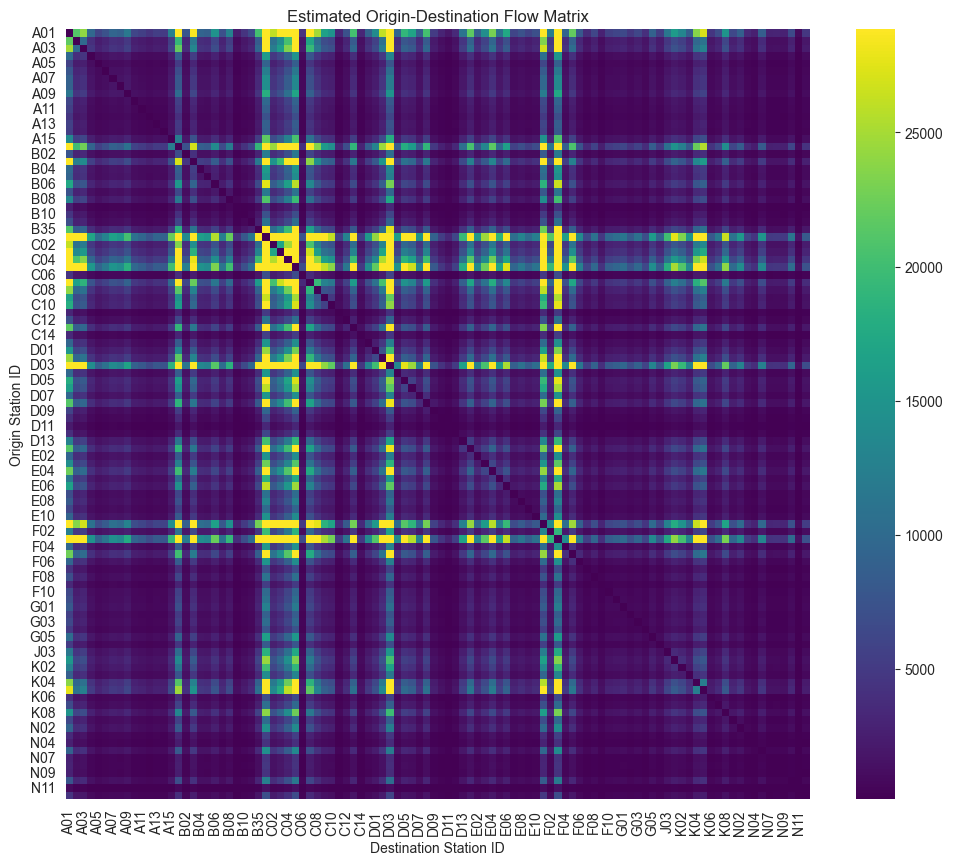

In [11]:
# Synthetic OD Matrix

# Aggregate station statistics
station_stats = rail_df.groupby('STOP_ID')[['AVG_BOARDINGS', 'AVG_ALIGHTINGS']].sum()

# Gravity Model Calculation
O = station_stats['AVG_BOARDINGS'].values.reshape(-1, 1)
D = station_stats['AVG_ALIGHTINGS'].values.reshape(1, -1)
total_traffic = station_stats['AVG_ALIGHTINGS'].sum()

# Create Matrix
od_df = pd.DataFrame((O * D) / total_traffic, index=station_stats.index, columns=station_stats.index)
np.fill_diagonal(od_df.values, 0)

# Name axes to prevent stacking collision
od_df.index.name = None
od_df.columns.name = None

# Stack and manually rename columns
od_pairs = od_df.stack().reset_index()
od_pairs.columns = ['Origin', 'Destination', 'Estimated_Trips']

print("Top 10 Estimated Passenger Flows:")
display(od_pairs.sort_values('Estimated_Trips', ascending=False).head(10))

# Visualize Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(od_df, cmap="viridis", robust=True)
plt.title("Estimated Origin-Destination Flow Matrix")
plt.xlabel("Destination Station ID")
plt.ylabel("Origin Station ID")
plt.show()

In [12]:
# Construct WMATA Network Topology
import networkx as nx

def build_wmata_graph():
    G = nx.Graph()
    
    # Define Line Sequences (Physical Tracks)
    lines = {
        'Red': [
            'Shady Grove', 'Rockville', 'Twinbrook', 'North Bethesda', 'Grosvenor-Strathmore', 
            'Medical Center', 'Bethesda', 'Friendship Heights', 'Tenleytown-AU', 'Van Ness-UDC', 
            'Cleveland Park', 'Woodley Park', 'Dupont Circle', 'Farragut North', 'Metro Center', 
            'Gallery Pl-Chinatown', 'Judiciary Square', 'Union Station', 'NoMa-Gallaudet U', 
            'Rhode Island Ave', 'Brookland-CUA', 'Fort Totten', 'Takoma', 'Silver Spring', 
            'Forest Glen', 'Wheaton', 'Glenmont'
        ],
        'Blue': [
            'Franconia-Springfield', 'Van Dorn St', 'King St-Old Town', 'Braddock Rd', 
            'Ronald Reagan Washington National Airport', 'Crystal City', 'Pentagon City', 
            'Pentagon', 'Arlington Cemetery', 'Rosslyn', 'Foggy Bottom-GWU', 'Farragut West', 
            'McPherson Square', 'Metro Center', 'Federal Triangle', 'Smithsonian', "L'Enfant Plaza", 
            'Federal Center SW', 'Capitol South', 'Eastern Market', 'Potomac Ave', 'Stadium-Armory', 
            'Benning Road', 'Capitol Heights', 'Addison Road', 'Morgan Boulevard', 'Downtown Largo'
        ],
        'Orange': [
            'Vienna', 'Dunn Loring', 'West Falls Church', 'East Falls Church', 'Ballston-MU', 
            'Virginia Sq-GMU', 'Clarendon', 'Court House', 'Rosslyn', 'Foggy Bottom-GWU', 
            'Farragut West', 'McPherson Square', 'Metro Center', 'Federal Triangle', 'Smithsonian', 
            "L'Enfant Plaza", 'Federal Center SW', 'Capitol South', 'Eastern Market', 'Potomac Ave', 
            'Stadium-Armory', 'Minnesota Ave', 'Deanwood', 'Cheverly', 'Landover', 'New Carrollton'
        ],
        'Green': [
            'Branch Ave', 'Suitland', 'Naylor Road', 'Southern Avenue', 'Congress Heights', 
            'Anacostia', 'Navy Yard-Ballpark', 'Waterfront', "L'Enfant Plaza", 'Archives', 
            'Gallery Pl-Chinatown', 'Mt Vernon Sq', 'Shaw-Howard U', 'U St', 'Columbia Heights', 
            'Georgia Ave-Petworth', 'Fort Totten', 'West Hyattsville', 'Hyattsville Crossing', 
            'College Park-U of Md', 'Greenbelt'
        ],
        'Yellow': [
            'Huntington', 'Eisenhower Ave', 'King St-Old Town', 'Braddock Rd', 
            'Ronald Reagan Washington National Airport', 'Crystal City', 'Pentagon City', 
            'Pentagon', "L'Enfant Plaza", 'Archives', 'Gallery Pl-Chinatown', 'Mt Vernon Sq'
        ],
        'Silver': [
            'Ashburn', 'Loudoun Gateway', 'Washington Dulles International Airport', 
            'Innovation Center', 'Herndon', 'Reston Town Center', 'Wiehle-Reston East', 
            'Spring Hill', 'Greensboro', 'Tysons', 'McLean', 'East Falls Church', 'Ballston-MU', 
            'Virginia Sq-GMU', 'Clarendon', 'Court House', 'Rosslyn', 'Foggy Bottom-GWU', 
            'Farragut West', 'McPherson Square', 'Metro Center', 'Federal Triangle', 'Smithsonian', 
            "L'Enfant Plaza", 'Federal Center SW', 'Capitol South', 'Eastern Market', 'Potomac Ave', 
            'Stadium-Armory', 'Benning Road', 'Capitol Heights', 'Addison Road', 'Morgan Boulevard', 
            'Downtown Largo'
        ]
    }
    
    # Add Edges
    for line_name, stations in lines.items():
        edges = list(zip(stations[:-1], stations[1:]))
        G.add_edges_from(edges, line=line_name)
        
    return G

# Initialize Graph
G_physical = build_wmata_graph()

print(f"Topology Built: {G_physical.number_of_nodes()} Stations, {G_physical.number_of_edges()} Connections")
print("Key Hubs:", sorted(G_physical.degree, key=lambda x: x[1], reverse=True)[:5])

Topology Built: 97 Stations, 99 Connections
Key Hubs: [("L'Enfant Plaza", 5), ('Metro Center', 4), ('Gallery Pl-Chinatown', 4), ('Fort Totten', 4), ('King St-Old Town', 3)]


Top 5 Structural Bottlenecks (Critical Fail Points):


,Bottleneck_Score,Hub_Score
L'Enfant Plaza,0.548830,0.052083
Gallery Pl-Chinatown,0.402156,0.041667
Pentagon,0.353947,0.031250
Rosslyn,0.334942,0.031250
Metro Center,0.332822,0.041667


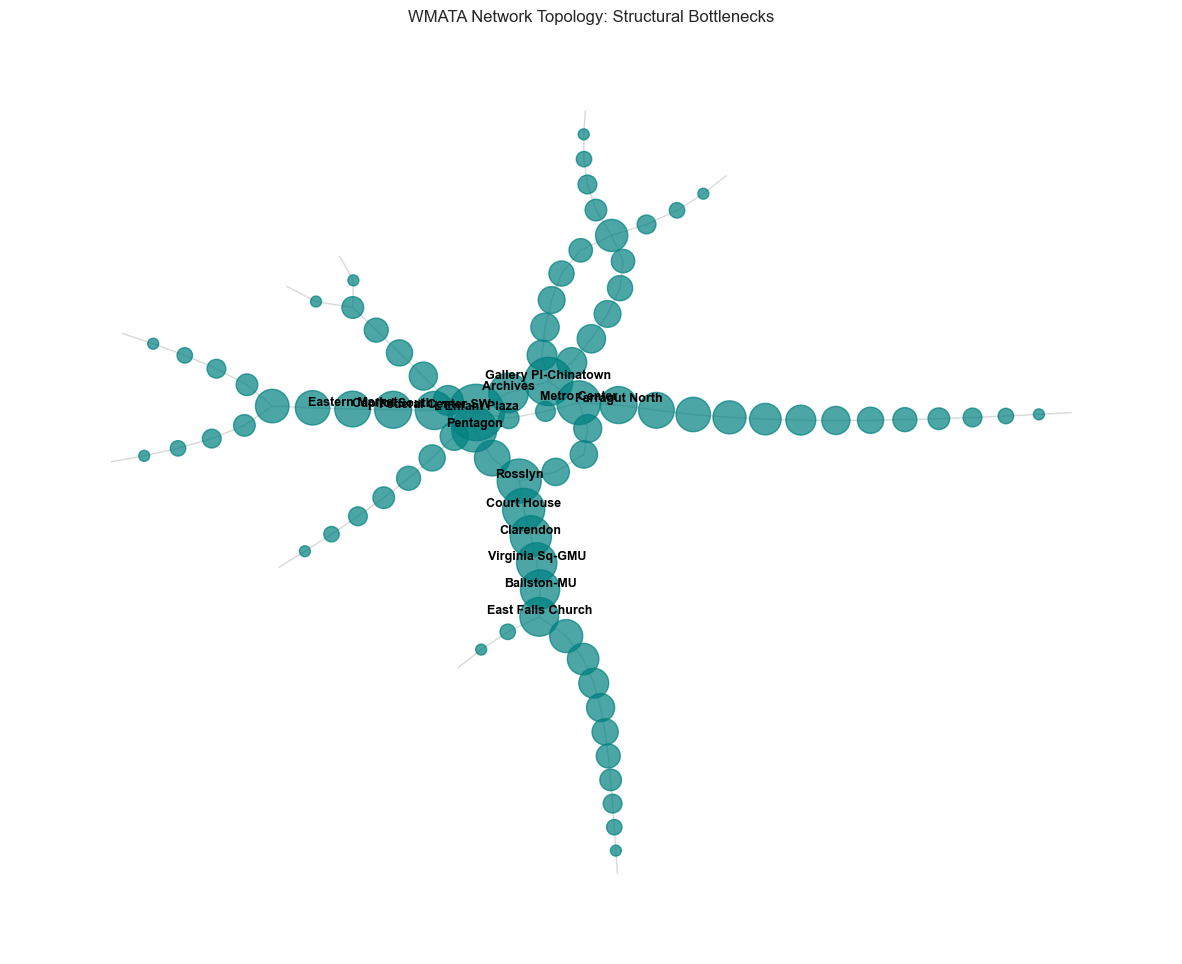

In [14]:
# Network Topology Analysis

# 1. Calculate Centrality Metrics
# Betweenness = How often a station is on the shortest path between two others (Bottleneck)
# Degree = How many direct connections a station has (Hub)
betweenness = nx.betweenness_centrality(G_physical)
degree = nx.degree_centrality(G_physical)

# 2. Organize into DataFrame
topology_df = pd.DataFrame({
    'Bottleneck_Score': pd.Series(betweenness),
    'Hub_Score': pd.Series(degree)
})

print("Top 5 Structural Bottlenecks (Critical Fail Points):")
display(topology_df.sort_values('Bottleneck_Score', ascending=False).head(5))

# 3. Visualize Network Structure 
plt.figure(figsize=(15, 12))

# Use a force-directed layout that simulates physical connections
pos = nx.kamada_kawai_layout(G_physical)

# Draw Network
nx.draw_networkx_edges(G_physical, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(
    G_physical, pos, 
    node_size=[v * 3000 for v in betweenness.values()], # Size by importance
    node_color='teal', 
    alpha=0.7
)

# Label only the top 15 most critical stations to avoid clutter
top_critical = topology_df.sort_values('Bottleneck_Score', ascending=False).head(15).index
labels = {node: node for node in top_critical}
nx.draw_networkx_labels(G_physical, pos, labels=labels, font_size=9, font_weight='bold', verticalalignment='bottom')

plt.title("WMATA Network Topology: Structural Bottlenecks")
plt.axis('off')
plt.show()